In [1]:
from osgeo import gdal
import rasterio
from pathlib import Path
import os
from tqdm.auto import tqdm
import itertools
from multiprocessing import Semaphore, Process


In [2]:
src_img = '../data/NW_Calvert/2016/20160803_Calvert_ChokedNorthBeach_georef_MOS_U0069_clean.tif'
src_labels = '../data/kelp_clean.tif'

In [ ]:
# Get X and Y dimensions of image

with rasterio.open(src_img) as img:
    w = img.width
    h = img.height
    
with rasterio.open(src_labels) as img:
    if w != img.width or h != img.height:
        raise RuntimeError("Label dataset must have the same extents as the image dataset")

print(w)
print(h)

In [ ]:
cpus = os.cpu_count()

semaphore = Semaphore(value=cpus)

# Create small image dataset
dest_d = Path('../data/calvert_choked_north_2016/')
dest_x = dest_d.joinpath('x')
dest_y = dest_d.joinpath('y')
dest_x.mkdir(parents=True, exist_ok=True)
dest_y.mkdir(parents=True, exist_ok=True)

crop_size = 200
x0s = list(range(0, w, crop_size))
y0s = list(range(0, h, crop_size))
origins = itertools.product(x0s, y0s)

def crop_to_png(sem, dest, src, x0, y0, crop_size):
    sem.acquire()
    options_list = [
        '-ot Byte',
        '-of PNG',
#         '-b 1',
#         '-b 2',
#         '-b 3',
        '-scale',
        f'-srcwin {x0} {y0} {crop_size} {crop_size}'
    ]
    gdal.Translate(dest, src, options=" ".join(options_list))
    sem.release()

for i, (x0, y0) in tqdm(enumerate(origins), total=len(x0s)*len(y0s)):
    # Crop label sections and save
    Process(target=crop_to_png, args=(semaphore, 
                                      str(dest_x.joinpath(f"{i}.png")), src_img, 
                                      x0, y0, crop_size)).start()
    
    Process(target=crop_to_png, args=(semaphore, 
                                      str(dest_y.joinpath(f"{i}.png")), src_labels, 
                                      x0, y0, crop_size)).start()

In [3]:
# Turn the above work into a nice function

def _crop_to_png(sem, dest, src, x0, y0, crop_size):
    sem.acquire()
    options_list = [
        '-ot Float32',
        '-of PNG',
        '-scale',
        f'-srcwin {x0} {y0} {crop_size} {crop_size}'
    ]
    gdal.Translate(dest, src, options=" ".join(options_list))
    sem.release()

def slice_and_dice_image(src_img, src_labels, dest_x, dest_y, crop_size=200, cpus=os.cpu_count()):
    semaphore = Semaphore(value=cpus)
    
    # Create small image dataset
    dest_x = Path(dest_x)
    dest_y = Path(dest_y)
    
    # Get X and Y dimensions of image
    with rasterio.open(src_img) as img:
        w = img.width
        h = img.height

    with rasterio.open(src_labels) as img:
        if w != img.width or h != img.height:
            raise RuntimeError("Label dataset must have the same extent as the image dataset")
            
    x0s = list(range(0, w, crop_size))
    y0s = list(range(0, h, crop_size))
    origins = itertools.product(x0s, y0s)    

    for i, (x0, y0) in tqdm(enumerate(origins), total=len(x0s)*len(y0s)):
        # Crop label sections and save
        dest = str(dest_x.joinpath(f"{i}.png"))
        Process(target=_crop_to_png, args=(semaphore, dest, src_img, x0, y0, crop_size)).start()

        dest = str(dest_y.joinpath(f"{i}.png"))
        Process(target=_crop_to_png, args=(semaphore, dest, src_labels, x0, y0, crop_size)).start()
    
    
# Create small image dataset
dest_d = Path('../data/calvert_choked_north_2016/')
dest_x = dest_d.joinpath('x')
dest_y = dest_d.joinpath('y')
dest_x.mkdir(parents=True, exist_ok=True)
dest_y.mkdir(parents=True, exist_ok=True)

src_img = '../data/NW_Calvert/2016/20160803_Calvert_ChokedNorthBeach_georef_MOS_U0069_clean.tif'
src_labels = '../data/kelp_clean.tif'

slice_and_dice_image(src_img, src_labels, str(dest_x), str(dest_y), crop_size = 200)

Process Process-27345:
Process Process-27545:
Process Process-27495:
Process Process-27455:
Process Process-27434:
Process Process-27525:
Process Process-27544:
Process Process-27618:
Process Process-27511:
Process Process-27133:
Process Process-27428:
Process Process-27514:
Process Process-27483:
Process Process-27179:
Process Process-27084:
Process Process-27615:
Process Process-27305:
Process Process-27578:
Process Process-27309:
Process Process-27200:
Process Process-27311:
Process Process-27184:
Process Process-27175:
Process Process-27420:
Process Process-27321:
Process Process-27148:
Process Process-27206:
Process Process-27666:
Process Process-27562:
Process Process-27657:
Process Process-27177:
Process Process-27149:
Process Process-27603:
Process Process-27232:
Process Process-27712:
Process Process-27219:
Process Process-27600:
Process Process-27113:
Process Process-27464:
Process Process-27399:
Process Process-27342:
Process Process-27625:
Process Process-27597:
Process Pro

Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/uav-classif/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-f282558c1437>", line 53, in <module>
    slice_and_dice_image(src_img, src_labels, str(dest_x), str(dest_y), crop_size = 200)
  File "<ipython-input-3-f282558c1437>", line 37, in slice_and_dice_image
    Process(target=_crop_to_png, args=(semaphore, dest, src_img, x0, y0, crop_size)).start()
  File "/home/tadenoud/anaconda3/envs/uav-classif/lib/python3.7/multiprocessing/process.py", line 111, in start
    _cleanup()
  File "/home/tadenoud/anaconda3/envs/uav-classif/lib/python3.7/multiprocessing/process.py", line 56, in _cleanup
    if p._popen.poll() is not None:
  File "/home/tadenoud/anaconda3/envs/uav-classif/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt

During

KeyboardInterrupt: 

Process Process-27140:
Process Process-27185:
Process Process-27202:
Process Process-27714:
Traceback (most recent call last):
Process Process-27076:
  File "/home/tadenoud/anaconda3/envs/uav-classif/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/uav-classif/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/uav-classif/lib/python3.7/site-packages/osgeo/gdal.py", line 2041, in <lambda>
    __setattr__ = lambda self, name, value: _swig_setattr(self, Dataset, name, value)
  File "<ipython-input-3-f282558c1437>", line 4, in _crop_to_png
    sem.acquire()
KeyboardInterrupt
KeyboardInterrupt

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/uav-classif/lib/python3.7/multiprocessing/process.py", line 29

In [7]:
# Delete images and labels that contain no useful data

for img_path in Path(dest_x).glob("*.png"):
    img_path = Path(img_path)
    img_path2 = img_path.with_suffix(".png.aux.xml")
    
    label_path = Path(dest_y).joinpath(img_path.name)
    label_path2 = label_path.with_suffix(".png.aux.xml")
    
    # TODO: Figure out how to dynamically determine st_size of empty image
    if img_path.stat().st_size == 195:
        # Del associated label files
        label_path.unlink()
        label_path2.unlink()
        
        # Del images
        img_path.unlink()
        img_path2.unlink()

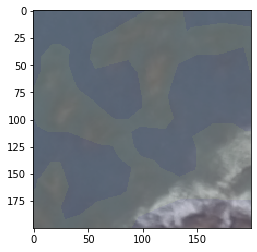

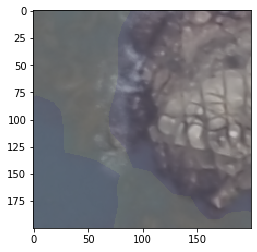

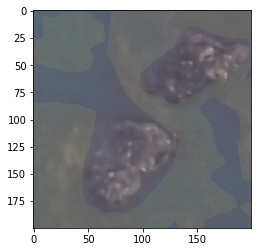

In [5]:
# Check that labels overlap images correctly

from utils.image import imshow
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

i = 4437
plt.figure()
plt.imshow(Image.open(str(dest_x.joinpath(f"{i}.png"))))

plt.imshow(Image.open(str(dest_y.joinpath(f"{i}.png"))), alpha=0.05)
plt.show()

i = 4438
plt.figure()
plt.imshow(Image.open(str(dest_x.joinpath(f"{i}.png"))))

plt.imshow(Image.open(str(dest_y.joinpath(f"{i}.png"))), alpha=0.05)
plt.show()


i = 4439
plt.figure()
plt.imshow(Image.open(str(dest_x.joinpath(f"{i}.png"))))

plt.imshow(Image.open(str(dest_y.joinpath(f"{i}.png"))), alpha=0.05)
plt.show()